This notebook provides a step by step guide for training a neural network in pytorch.

The steps usually include

- load data
- pre-process and transform data
- create a train, validation and test set
- create a model
- define learning rate, optimizer, loss function
- define a training and validation loop
- evaluate on test set

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

## Loading Data

For this notebook I will be using the FashionMNIST dataset, downloding using `torchvision.datasets`.

In [18]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5), (0.5))
])


In [19]:
# Download data

train_data = torchvision.datasets.FashionMNIST(
    train=True,
    root='.',
    download=True,
    transform=transform
)

test_data = torchvision.datasets.FashionMNIST(
    train=False,
    root='.',
    download=True,
    transform=transform
)

In [20]:
# Split trian data to train and validation set
train_set, val_set = torch.utils.data.random_split(train_data, [50000, 10000])

### Define Data Loader

The `DataLoader` class in the PyTorch `utils` package helps create data iterators in batches.

DataLoader can load data from
- Dataset Classes
- Tensors or Arrays of data
- Directory of data (image directory, etc ...)
- hd5 files
- Pandas DataFrames or Numpy Arrays/Files (.npy)

and more ...

In [21]:
batch_size= 32

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size= batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size= batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size= batch_size,
    shuffle=True
)

## Define a Model

There are two available ways to define a model in pytorch

- Functional API - defined using a custom class inheriting `nn.Module`
- Sequential API - defined using `nn.Sequention()` class object

#### Functional API

Defined using a custom class inheriting `nn.Module`.

as it inherits from nn.Module we need to define a `forward()` method to do forward pass.

In [55]:
# Functional API Model

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(784, 256)  # image is 28 * 28
        self.activation = nn.ReLU()
        self.hidden_layer_1 = nn.Linear(256, 128)
        self.hidden_layer_2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 10)

    def forward(self, x):  # ✅ x added here
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.hidden_layer_1(x)
        x = self.activation(x)
        x = self.hidden_layer_2(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x



#### Sequential API

Defined using `nn.Sequention()` class object.

This takes specified layers in a sequence, as `nn.Linear`, `nn.ReLU`, `nn.Conv2d` etc.

In [23]:
seq_model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

## Configurations

In [60]:
## model to device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
func_model = Net().to(device)
seq_model = seq_model.to(device)

In [61]:
MODEL = "F" # decide which model to use

model = func_model if MODEL == "F" else seq_model # use functional or sequential model

Define `optimizer`, `loss` and `learning rate` for your model.

In [66]:
lr = 0.0001
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

## define a training loop

### define train and val epoch function

In [77]:
def train_epoch():
  model.train() # set model to training

  correct = 0
  running_loss = 0
  total = 0

  for imgs, labels in train_loader:
    imgs = imgs.reshape(-1,784).to(device) # shape (batch_size,786)
    labels = labels.reshape(-1,).to(device) # shape(batch_size)

    preds = model(imgs)
    loss = loss_fn(preds, labels)

    optim.zero_grad()
    loss.backward()
    optim.step()

    running_loss += loss.detach()

    # Calculate Accuracy
    preds = torch.tensor([torch.argmax(pred) for pred in preds]).float() # get the prediction each is of shape ((1, 10) for now)
    correct += (preds == labels).sum().item()
    total += len(labels)

  running_loss = running_loss / len(train_loader)
  accuracy = correct / total

  return running_loss, accuracy

In [78]:
def val_epoch():
  model.eval() # set model to evaluation
  correct = 0
  running_loss = 0
  total = 0

  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.reshape(-1, 784).to(device) # shape (batch_size,786)
      labels = labels.reshape(-1, ).to(device) # shape(batch_size)

      preds = model(imgs)
      loss = loss_fn(preds, labels)

      running_loss += loss.detach()

      # Calculate Accuracy
      preds = torch.tensor([torch.argmax(pred) for pred in preds]) # get the prediction each is of shape ((1, 10) for now)
      correct += (preds == labels).sum().item()
      total += len(labels)
      accuracy = correct / total

  running_loss = running_loss / len(train_loader)
  accuracy = correct / total

  return running_loss, accuracy


### train

In [80]:
epochs = 10

# list to keep track per epoch for plotting
train_losses, train_acuracies = [], []
val_losses, val_acuracies = [], []

for i in range(1, 10):
  train_loss, train_acc = train_epoch()
  val_loss, val_acc = val_epoch()

  # append results
  train_losses.append(train_loss)
  train_acuracies.append(train_acc)
  val_losses.append(val_loss)
  val_acuracies.append(val_acc)


  print(f"Epoch {i}:")
  print(f"Train Loss: {train_loss} Train Acc: {train_acc}")
  print(f"Val Loss: {val_loss} Val Acc: {val_acc} \n")


Epoch 1:
Train Loss: 0.2928917407989502 Train Acc: 0.89558
Val Loss: 0.06771618872880936 Val Acc: 0.8803 

Epoch 2:
Train Loss: 0.2826750874519348 Train Acc: 0.89688
Val Loss: 0.07001548260450363 Val Acc: 0.8769 

Epoch 3:
Train Loss: 0.27520066499710083 Train Acc: 0.89986
Val Loss: 0.0654890388250351 Val Acc: 0.8834 

Epoch 4:
Train Loss: 0.2645720839500427 Train Acc: 0.90428
Val Loss: 0.06785129010677338 Val Acc: 0.8759 

Epoch 5:
Train Loss: 0.25728845596313477 Train Acc: 0.90586
Val Loss: 0.06546655297279358 Val Acc: 0.8858 

Epoch 6:
Train Loss: 0.24997323751449585 Train Acc: 0.90828
Val Loss: 0.066066674888134 Val Acc: 0.8816 

Epoch 7:
Train Loss: 0.24276527762413025 Train Acc: 0.91124
Val Loss: 0.0638963133096695 Val Acc: 0.888 

Epoch 8:
Train Loss: 0.23658522963523865 Train Acc: 0.91402
Val Loss: 0.06502663344144821 Val Acc: 0.8852 

Epoch 9:
Train Loss: 0.2302255630493164 Train Acc: 0.9166
Val Loss: 0.06525292992591858 Val Acc: 0.8824 



## Plotting Loss and Accuracy

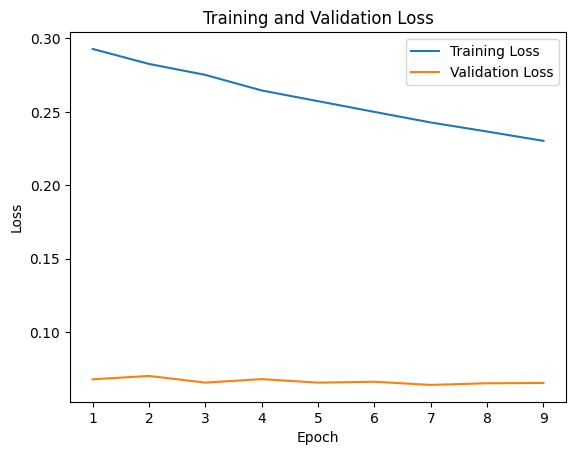

In [85]:
import matplotlib.pyplot as plt

# Assuming you have lists: train_losses and val_losses
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

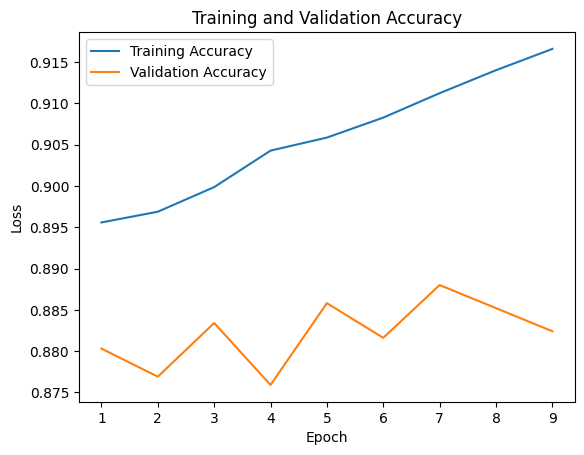

In [86]:
import matplotlib.pyplot as plt

# Assuming you have lists: train_losses and val_losses
epochs = range(1, len(train_acuracies) + 1)

plt.plot(epochs, train_acuracies, label='Training Accuracy')
plt.plot(epochs, val_acuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Testing Model

In [89]:
# Define a test function

def test_model():
  model.eval()
  correct = 0
  running_loss = 0
  total = 0

  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.reshape(-1, 784).to(device) # shape (batch_size,786)
      labels = labels.reshape(-1, ).to(device) # shape(batch_size)

      preds = model(imgs)
      loss = loss_fn(preds, labels)

      running_loss += loss.detach()

      # Calculate Accuracy
      preds = torch.tensor([torch.argmax(pred) for pred in preds]) # get the prediction each is of shape ((1, 10) for now)
      correct += (preds == labels).sum().item()
      total += len(labels)
      accuracy = correct / total

  running_loss = running_loss / len(train_loader)
  accuracy = correct / total

  return running_loss, accuracy

In [91]:
loss, acc = test_model()
print(f"Test Loss is: {loss}")
print(f"Test Accuracy is: {acc}")

Test Loss is: 0.06528423726558685
Test Accuracy is: 0.8824
